# Прогнозы и предсказания для сети фитнес-центров

Цель проекта: провести анализ и подготовить план действий по удержанию клиентов.

Задачи проекта: 
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## 1. Импорт файла и библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

path = '/datasets/gym_churn.csv'

if os.path.exists(path):
    gym_churn = pd.read_csv(path)
else:
    print('Неверно указан путь к файлу')

Импортируем необходимые библиотеки и датасеты.

In [2]:
display(gym_churn.head())
display(gym_churn.info())
print('Кол-во пропусков:')
print(gym_churn.isna().sum())
print('\nКол-во дубликатов:', gym_churn.duplicated().sum())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Кол-во пропусков:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Кол-во дубликатов: 0


Изучим данные из файла gym_churn. Всего в таблице 4000 строк и 14 столбцов, - 10 столбцов целочисленного типа и 4 типа float. Пропусков и дубликатов в данных нет. 

## 2. Предобработка данных

In [3]:
gym_churn.columns = gym_churn.columns.str.lower()

Приведем названия столбцов к нижнему регистру.

In [4]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

Столбец с даными о сроке до окончания текущего действующего абонемента (в месяцах) month_to_end_contract приведем к целочисленному типу.

## 3. Исследовательский анализ данных (EDA)

In [5]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В датасете есть бинарные переменные:
- gender (пол)
- near_location (проживание или работа в районе, где находится фитнес-центр)
- partner (является ли клиент сотрудником компании-партнёра клуба)
- promo_friends (факт первоначальной записи в рамках акции «приведи друга»)
- phone (наличие контактного телефона)
- group_visits (факт посещения групповых занятий)
- churn (факт оттока в текущем месяце)

В среднем:
- длительность текущего действующего абонемента составляет 4,5 месяца
- возраст среднего пользователя - 29 лет
- суммарная выручка от других услуг фитнес-центра - 147 у.е.
- срок до окончания текущего действующего абонемента (в месяцах) - 4 месяца
- время с момента первого обращения в фитнес-центр (в месяцах) - 3,7 мес.
- средняя частота посещений в неделю за все время с начала действия абонемента - 1,9 раза
- средняя частота посещений в неделю за предыдущий месяц - 1,8 раза

In [6]:
churn_grouped = (gym_churn.groupby('churn')
                    .agg('mean')
                    .reset_index()
                    )
churn_grouped

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По всем показателям, кроме пола, показатели для тех, кто в текущем месяце перестал посещать клуб, ниже, чем для оставшихся клиентов. Наиболее сильно эта разница заметна в длительности текущего абонемента (contract_period) и сроке до окончания текущего действующего абонемента (в месяцах) (month_to_end_contract) - похоже, чем меньше остается времени до окончания абонемента, тем вероятнее, что пользователь перестанет посещать клуб. Время с момента первого обращения в фитнес-центр (в месяцах) (lifetime) значительно выше для тех, кто остался в клубе.

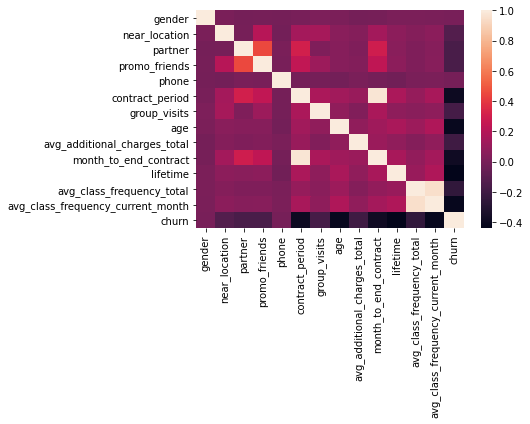

In [7]:
cm_heatmap = sns.heatmap(gym_churn.corr())

Наблюдается сильная корреляция между переменными срока до окончания текущего действующего абонемента (в месяцах) (month_to_end_contract) и длительностью текущего абонемента (contract_period), а также между средней частотой посещений в неделю за предыдущий месяц (avg_class_frequency_current_month) и средней частотой посещений в неделю за все время с начала действия абонемента (avg_class_frequency_total).

In [8]:
gym_churn_clean = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

Создадим датасет gym_churn_clean, очищенный от мультиколлинеарных признаков. Модели будем обучать уже на очищенном датасете.

Клиенты, которые остались


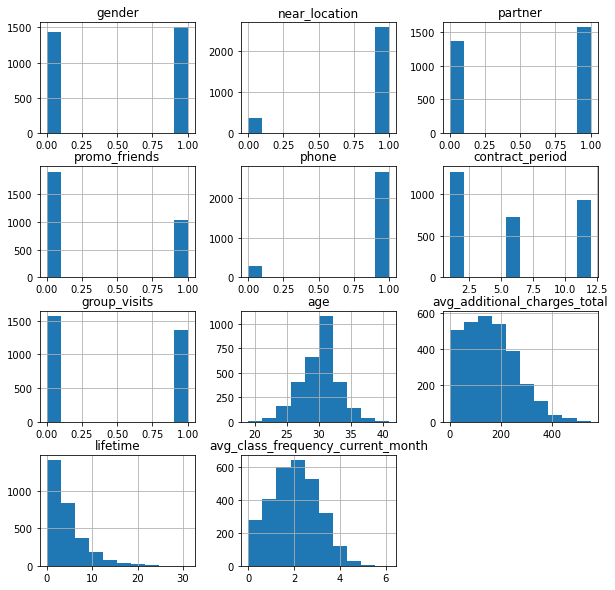

In [10]:
print('Клиенты, которые остались')
gym_churn_clean[gym_churn['churn']==0].drop('churn', axis=1).hist(figsize=(10, 10));

Клиенты, которые ушли


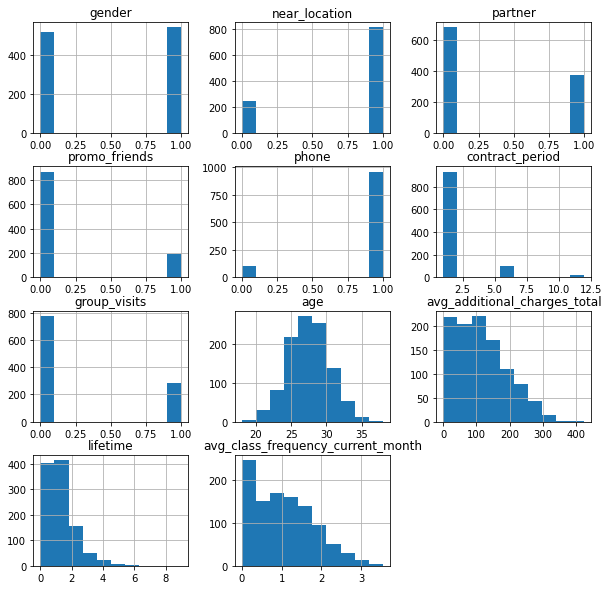

In [11]:
print('Клиенты, которые ушли')
gym_churn_clean[gym_churn['churn']==1].drop('churn', axis=1).hist(figsize=(10, 10));

- среди мужчин и женщин примерно поровну тех, кто остался в клубе и тех, кто перестал его посещать, так же как и среди живущих рядом с клубом и живущих далеко; 
- среди сотрудников компании-партнёра клуба больше оставшихся в клубе, чем среди остальных; то же можно сказать и о тех, кто пришел по промоакции "приведи друга"
- те, кто покупает абонемент на срок от 6 мес включительно, реже перестают ходить на фитнес; так же как и те, кто посещает групповые занятия
- относительно молодые клиенты чаще бросают фитнес
- чем меньше месяцев остается до окончания абонемента, тем чаще клиенты перестают посещать клуб
- по остальным переменным распределения оставшихся в клубе и покинувших его схожи, с учетом того, что оставшихся клиентов в выборке почти в 3 раза больше чем переставших посещать клуб

## 4. Модель прогнозирования оттока пользователей

In [12]:
y = gym_churn_clean['churn']
X = gym_churn_clean.drop(['churn'], axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)

X_test_st = scaler.transform(X_test)

models = [LogisticRegression(random_state=0),
          RandomForestClassifier(random_state=0) 
         ]

def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape

def make_prediction(m, X_train_st, y_train, X_test_st, y_test):
    model = m
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )

for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)   
    print('')

LogisticRegression(random_state=0)
accuracy:0.90 precision:0.79 recall:0.82

RandomForestClassifier(random_state=0)
accuracy:0.90 precision:0.81 recall:0.75



Результаты по метрикам у LogisticRegression() и RandomForestClassifier() довольно близки, но логистическая регрессия оказалась чуть лучше по recall, а случайный лес - по precision.

## 5. Кластеризация клиентов

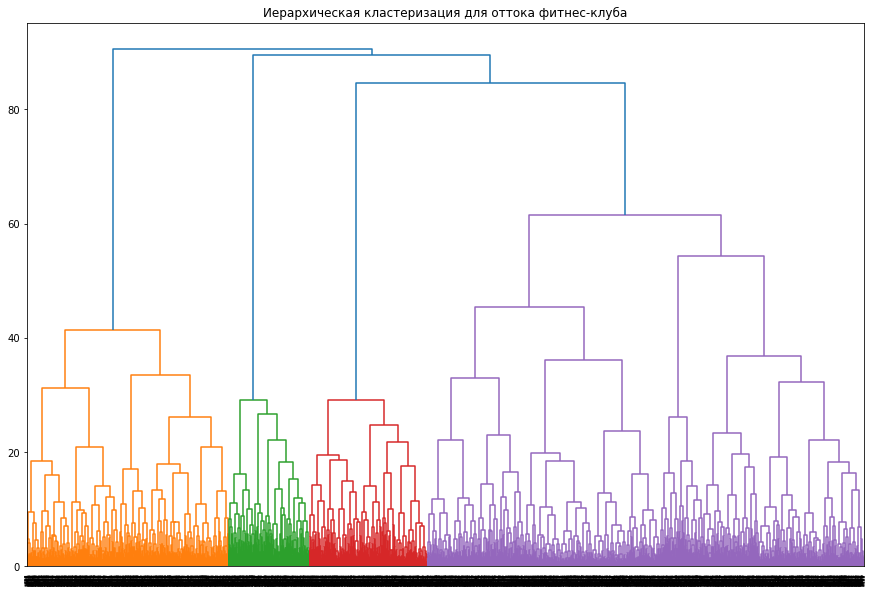

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для оттока фитнес-клуба')
plt.show()

На основании полученной дендрограммы можно предположить, что признаки разделяются на 4 кластера.

In [14]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

km = KMeans(n_clusters = 5, random_state = 0)

labels = km.fit_predict(x_sc)

gym_churn_clean['cluster_name'] = labels

Примем за число кластеров n=5 для сопоставимости с результатами коллег.

In [15]:
(gym_churn_clean.groupby('cluster_name')
                    .agg('mean')
                    .reset_index()
                    )

,cluster_name,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


При рассмотрении средних значений признаков для кластеров можно заметить, что:
- в 3-ий кластер попадают в основном клиенты со средним сроком абонемента 6 мес, показатель оттока у них самый низкий. Они в среднем чаще всех посещают групповые занятия и чаще других пользуются другими услугами фитнес-центра. Также здесь довольно мало тех, кто пришел по программе "приведи друга" и почти все живут в районе фитнес-клуба. Сюда входят клиенты с наиболее высоким средним возрастом.
- Наибольший отток у клиентов из кластера 2. Все они живут в районе фитнес-клуба, у них в среднем самый короткий срок абонемента, они меньше всех тратятся на доп. услуги фитнес-центра и реже всего его посещают его. Сюда входят в среднем самые молодые клиенты.
- В кластере 1 отток тоже довольно высокий, все клиенты здесь живут НЕ в районе фитнес-центра и тоже относительно редко посещали клуб в последний месяц. 

Кластер 0


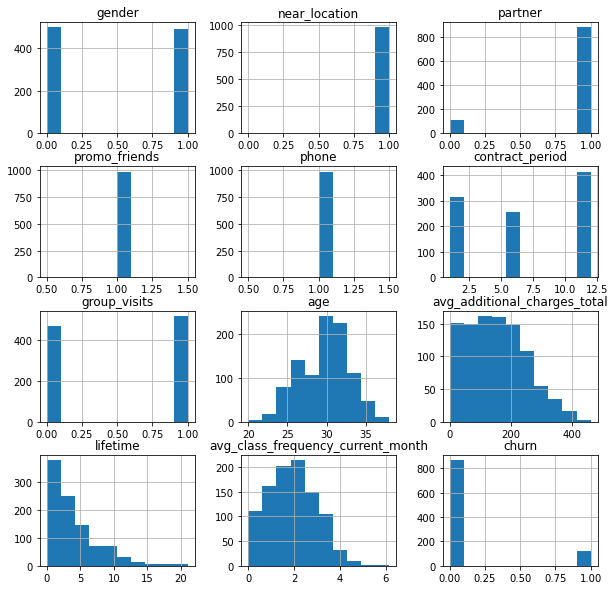

In [16]:
print('Кластер', 0)
gym_churn_clean[gym_churn_clean['cluster_name']==0].drop('cluster_name', axis=1).hist(figsize=(10, 10));

Кластер 1


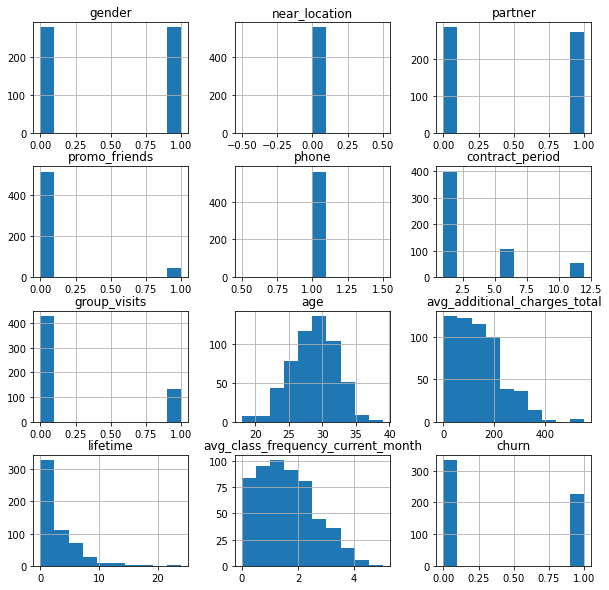

In [17]:
print('Кластер', 1)
gym_churn_clean[gym_churn_clean['cluster_name']==1].drop('cluster_name', axis=1).hist(figsize=(10, 10));

Кластер 2


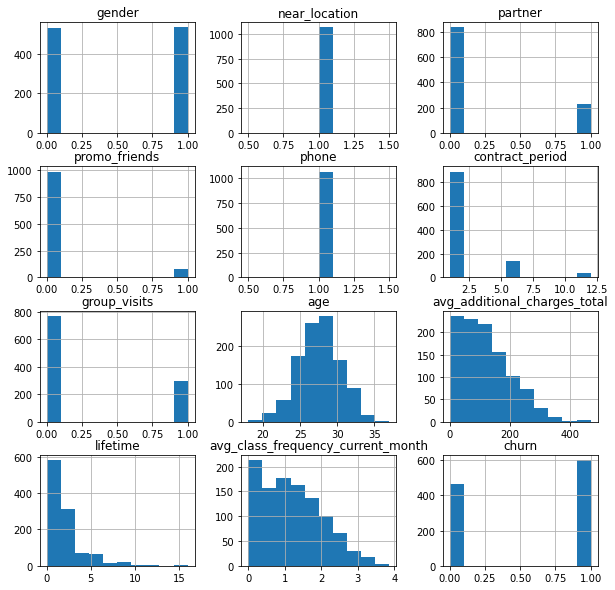

In [18]:
print('Кластер', 2)
gym_churn_clean[gym_churn_clean['cluster_name']==2].drop('cluster_name', axis=1).hist(figsize=(10, 10));

Кластер 3


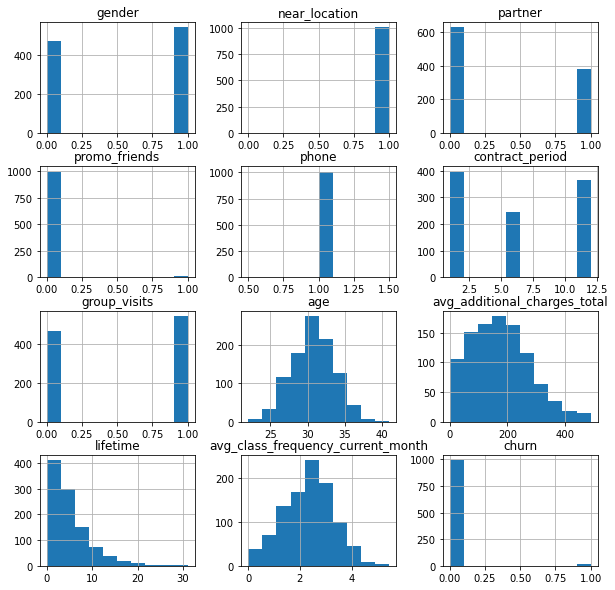

In [19]:
print('Кластер', 3)
gym_churn_clean[gym_churn_clean['cluster_name']==3].drop('cluster_name', axis=1).hist(figsize=(10, 10));

Кластер 4


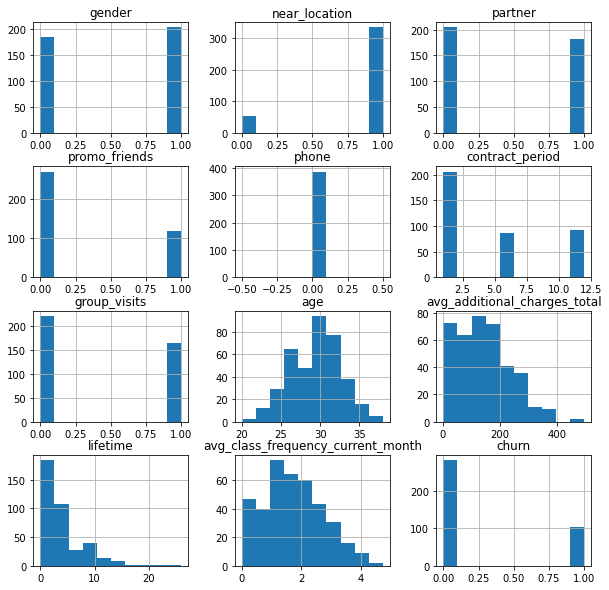

In [20]:
print('Кластер', 4)
gym_churn_clean[gym_churn_clean['cluster_name']==4].drop('cluster_name', axis=1).hist(figsize=(10, 10));

- У самого "проблеммного" кластера 2 основная часть значений посещаемости клуба сосредоточена у нуля, так же, как и значения расходов на доп. услуги и время с момента первого обращения в фитнес-центр (в месяцах).
- В наименее "проблемном" кластере 3 lifetime также в основном сосредоточен у 0, зато средние расходы на доп. услуги сконцентрированы в районе 200 у.е., а средняя посещаемость за прошлый месяц - в районе 3 раз. Средний возраст клиентов здесь чуть выше, чем в кластере 2 (30 лет против 27), а распределение возраста больше скошено вправо.

In [21]:
(gym_churn_clean.groupby('cluster_name')
                    .agg('mean')
                    .reset_index()
                    )[{'cluster_name', 'churn'}].sort_values(by='churn', ascending=False)

,churn,cluster_name
2,0.563910,2
1,0.403226,1
4,0.266839,4
0,0.119797,0
3,0.014896,3


Т.к. факт оттока клиентов в нашем случае бинарная переменная, churn_rate можем рассчитать как среднее значение оттока по каждому классу. В таблице кластеры отсортированы от самых "проблемных" к самым "лояльным". В кластере 2 больше половины клиентов ушли из клуба. 

# Выводы

В рамках исследования была проведена кластеризация пользователей и выявлены характерные черты каждой из 5 групп.
Самый большой отток в группах, где:
- клиенты относительно молоды (~27 лет)
- срок абонемента короткий (~1 мес.)
- меньше других покупают доп. услуги
- редко посещают фитнес (~ 1 раз в неделю)

- либо клиенты живут/работают не в районе фитнес-центра

При этом наиболее низкий отток в группе, где:
- клиенты относительно страше (~30 лет)
- срок абонемента длинный (~6 мес.)
- больше половины из этого кластера посещают групповые занятия
- часто посещают клуб (2 и более раза в неделю)
- редко покупают абонемент по промоакции "приведи друга"

Вероятно фитнес-клубу имеет смысл отслеживать частоту посещений клиента. Если он стал ходить реже, можно аккуратно напомнить ему о себе, предложив например особые условия на доп. услуги либо оповестить его о новинках клуба. 
Скорее всего в оттоке краткосрочных клиентов нет особой проблемы, т.к. люди могут покупают абонементы на месяц чтобы попробовать фитнес впервые (либо впервые именно в этом клубе). Это лучше, чем если бы они не пришли вообще, испугавшись обязывающего и более дорогостоящего (полу)годового абонемента.

Стоит рассмотреть программу групповых занятий в отношении более молодых клиентов. Они редко посещают групповые занятия потому что в принципе не любят их? Либо основная часть занятий ориентирована на людей более старшего возраста? В первом случае можно проработать альтернативы групповым занятиям (программы с тренером, более современные тренажеры, доп. услуги), во втором - ввести новые более популярные среди данной возрастной группы форматы совместных тренировок. 

При возможном планировании расширения фитнес-сети стоит учесть наиболее частое место проживания/работы клиентов и располагаться в данных районах. Судя по всему несколько небольших клубов формата "у дома" будут пользоваться в сумме большей популярностью, чем один крупный, но отдаленный клуб.